# Import

In [75]:
from pathlib import Path
import os
import sys

project_dir = Path('__main__').resolve().parent.parent
sys.path.append(f'{project_dir}/')

import pandas as pd
import numpy as np
import scipy.sparse as sp
import re

from feature_engine.encoding import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

from feature_engine.encoding import OrdinalEncoder

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Data

In [76]:
df = pd.read_parquet(os.path.join(project_dir, 'data', 'basic_processed', 'basic.parquet.gzip'))

In [218]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from feature_engine.encoding import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt

class Correlation():
    def __init__(self, vars_cat=[], vars_num=[], fig_size=(10,10)):
        self.vars_cat = vars_cat
        self.vars_num = vars_num
        self.fig_size = fig_size
    
    def __encoding_cats(self, X):
        encOrd = OrdinalEncoder(encoding_method='arbitrary')
        X_tmp = encOrd.fit_transform(X[self.vars_cat])
        return X_tmp
    
    def categorical_correlation(self, X, y, max_cor=0.9):
        
        X_tmp = self.__encoding_cats(X)
        self.vars_cat = self.best_features(X_tmp, y, self.vars_cat)
        
        corr_matrix = X_tmp[self.vars_cat].corr(method='spearman').abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        vars_remove = [column for column in upper.columns if any(upper[column] > max_cor)]
        
        return vars_remove
    
    def numerical_correlation(self, X, y, max_cor):
        
        self.vars_num = self.best_features(X, y, self.vars_num)
        corr_matrix = X[self.vars_num].corr(method='pearson').abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        vars_remove = [column for column in upper.columns if any(upper[column] > max_cor)]
        
        return vars_remove
    
    def best_features(self, X, y, variables):
        #ANOVA
        slkb = SelectKBest(score_func=f_classif, k='all').fit(X[variables], y)
        _ , best_vars = zip(*sorted(zip(slkb.scores_, slkb.get_feature_names_out()), reverse=True))
        
        return list(best_vars)
    
    def remove_correlation(self, X, y, max_cor=0.9, mode='both'):
        
        if mode == 'both':
            vars_remove = self.numerical_correlation(X, y, max_cor)
            vars_remove = vars_remove + self.categorical_correlation(X, y, max_cor)
            
        elif mode == 'num':
            vars_remove = self.numerical_correlation(X, y, max_cor)
            
        elif mode == 'cat':
            vars_remove = self.categorical_correlation(X, y, max_cor)
            
        return vars_remove
    
    def plot(self, X, mode='both'):
        
        if mode == 'both':     
            X_tmp = self.__encoding_cats(X)
            corr_cat = X_tmp[self.vars_cat].corr(method='spearman')
            corr_num = X[self.vars_num].corr(method='pearson')
            
            fig, axs = plt.subplots(2, 1, figsize=self.fig_size)
            
            sns.heatmap(corr_cat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axs[0])
            axs[0].set_title('Heatmap de Correlação Spearman Categóricas')
            
            sns.heatmap(corr_num, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axs[1])
            axs[1].set_title('Heatmap de Correlação Pearson Numéricas')
            
        elif mode == 'cat':
            X_tmp = self.__encoding_cats(X)
            corr_cat = X_tmp[self.vars_cat].corr(method='spearman')
            
            plt.figure(figsize=self.fig_size)
            sns.heatmap(corr_cat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
            plt.title('Heatmap de Correlação Spearman Categóricas')
        
        elif mode == 'num':
            corr_num = X[self.vars_num].corr(method='pearson')
        
            plt.figure(figsize=self.fig_size)
            sns.heatmap(corr_num, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
            plt.title('Heatmap de Correlação Pearson Numéricas')
        
        plt.show()
        

In [219]:
vars_num = df.select_dtypes(exclude=['object', 'string']).columns
vars_num

Index(['org_domain', 'com_domain', 'gov_domain', 'qtd_args_query', 'len_URL',
       'qty_dots_URL', 'qty_hyphens_URL', 'qty_undescore_URL',
       'qty_numbers_URL', 'qty_vogais_URL', 'qty_especiais_URL', 'len_domain',
       'qty_dots_domain', 'qty_hyphens_domain', 'qty_undescore_domain',
       'qty_numbers_domain', 'qty_vogais_domain', 'qty_especiais_domain',
       'len_query', 'qty_dots_query', 'qty_hyphens_query',
       'qty_undescore_query', 'qty_numbers_query', 'qty_vogais_query',
       'qty_especiais_query', 'len_file', 'qty_dots_file', 'qty_hyphens_file',
       'qty_undescore_file', 'qty_numbers_file', 'qty_vogais_file',
       'qty_especiais_file', 'len_file_name', 'qty_dots_file_name',
       'qty_hyphens_file_name', 'qty_undescore_file_name',
       'qty_numbers_file_name', 'qty_vogais_file_name',
       'qty_especiais_file_name', 'len_file_extension',
       'qty_dots_file_extension', 'qty_hyphens_file_extension',
       'qty_undescore_file_extension', 'qty_numbers_fi

In [220]:
vars_cat = ['file_extension']

In [221]:
df['target'] = df.Label.apply(lambda x: 1 if x == 'bad' else 0)

In [222]:
corr = Correlation(vars_cat,vars_num)

In [223]:
vars_remove = corr.remove_correlation(df, df.target, mode='num')
vars_remove

aqui1


C:\Users\diego\anaconda3\envs\favorite-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


aqui2
aqui3


['len_domain',
 'len_URL',
 'len_query',
 'qty_vogais_query',
 'len_file_extension',
 'qty_vogais_file_extension',
 'qty_dots_file',
 'len_file',
 'qty_hyphens_file',
 'qty_vogais_URL',
 'qty_vogais_file',
 'qty_especiais_file',
 'qty_dots_file_name',
 'qty_vogais_file_name']

In [214]:
corr.fig_size = (40,10)

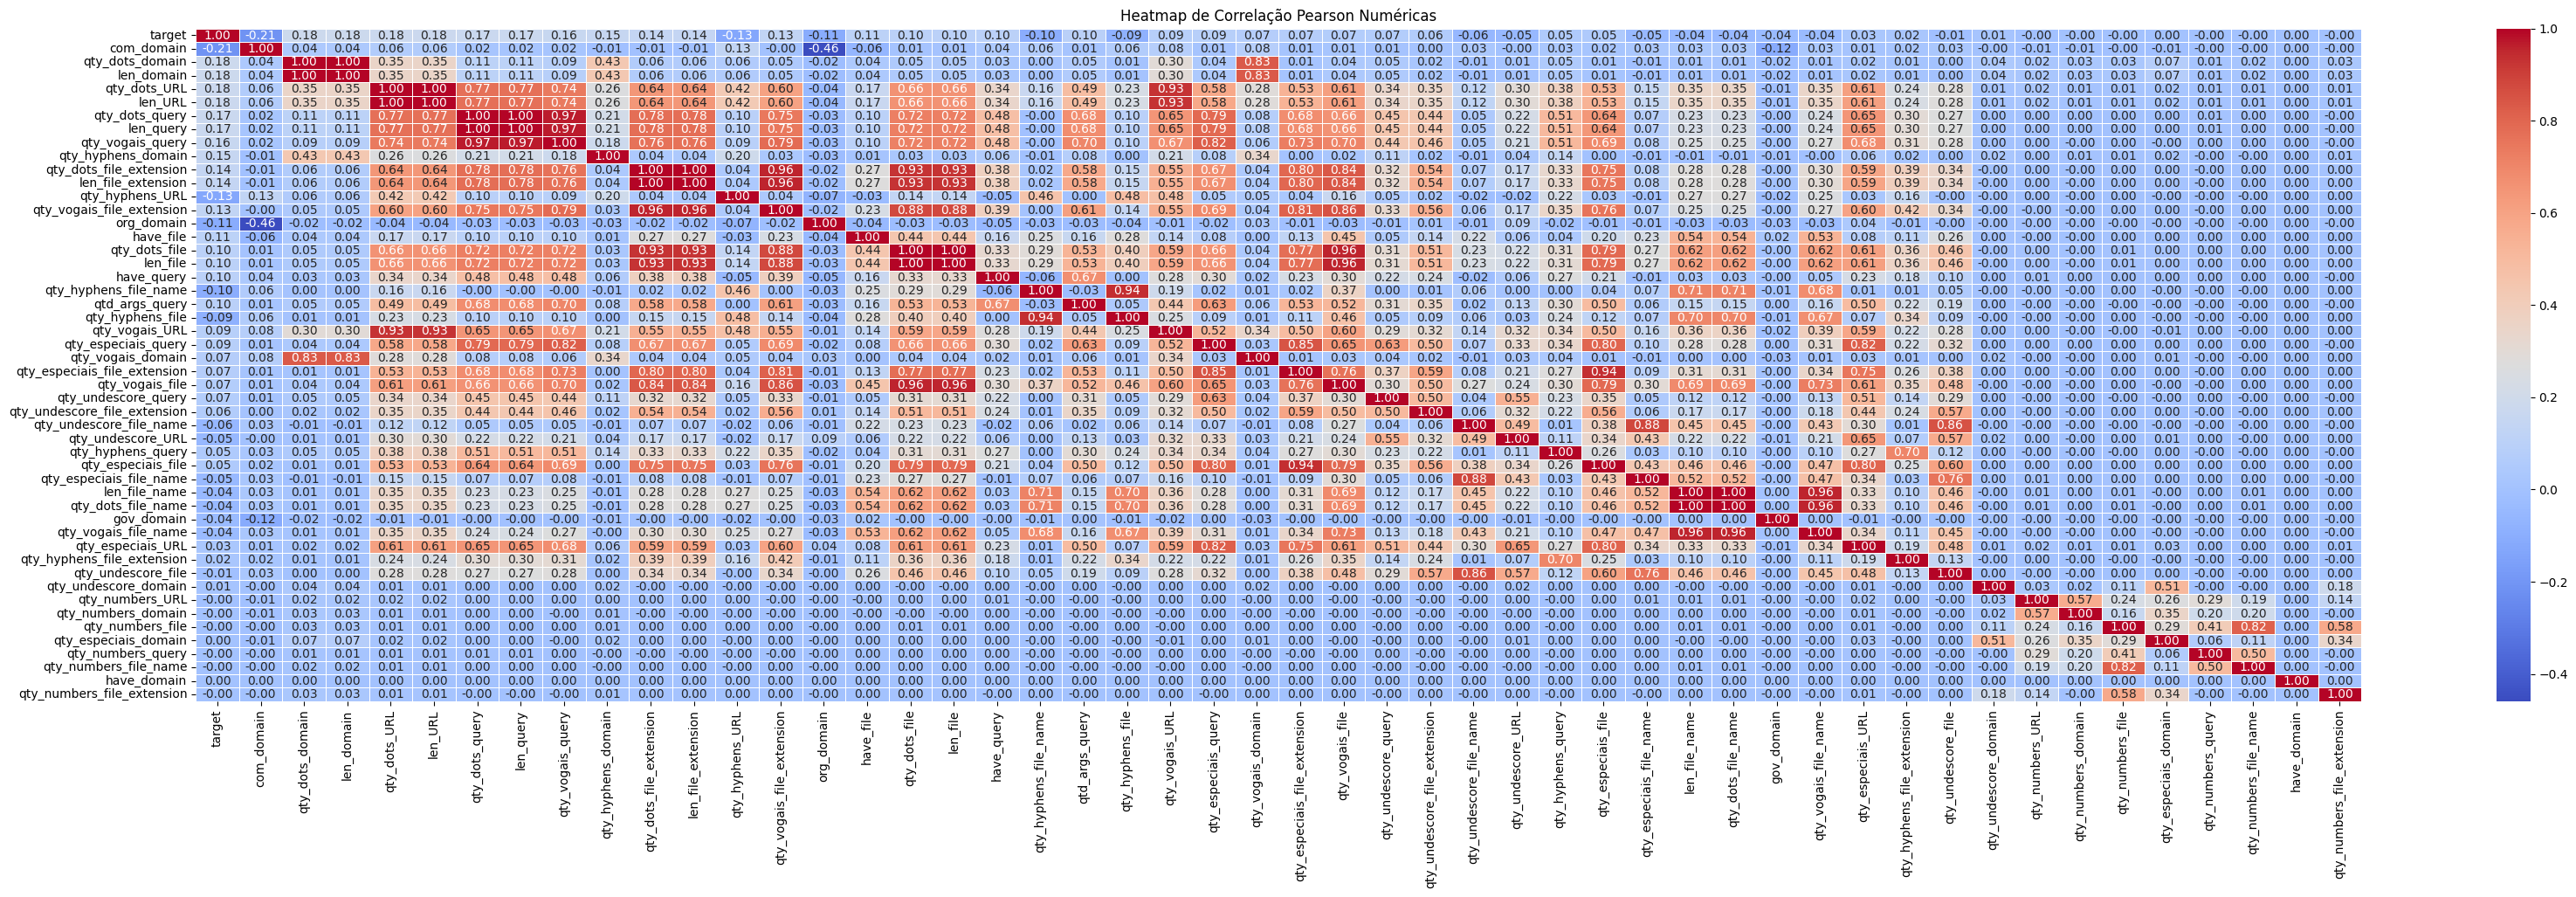

In [215]:
corr.plot(df, mode='num')